In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
import os
from tensorflow.keras.models import Model
#from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import seaborn as sn


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
def get_data_generators():
    train_dir = '/kaggle/input/private-datasetrar/224x224/train'
    valid_dir = '/kaggle/input/private-datasetrar/224x224/valid'
    test_dir = '/kaggle/input/private-datasetrar/224x224/test'

    batch_size = 32
    img_height, img_width = (224, 224)

    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.4
    )
    train_generator = train_datagen.flow_from_directory(
        directory=train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )
    valid_generator = train_datagen.flow_from_directory(
        directory=valid_dir,
        target_size=(img_height, img_width),
        batch_size=1,
        class_mode='categorical',
        subset='validation'
    )
    test_generator = train_datagen.flow_from_directory(
        directory=test_dir,
        target_size=(img_height, img_width),
        batch_size=1,
        class_mode='categorical',
        subset='validation'
    )
    
    return train_generator, valid_generator, test_generator


In [3]:
def InceptionV3Net(input_shape, num_classes):
    inception = InceptionV3(input_shape=input_shape, weights='imagenet', include_top=False)
    # train all existing weights
    for layer in inception.layers:
        layer.trainable = False

    model = Sequential([
        inception,
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(rate=0.2),
        Dense(num_classes, activation='softmax')
    ], name='InceptionV3Net')
    return model


In [4]:
def compile_and_fit_model(model, train_generator, valid_generator):
    EPOCHS = 50
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint_filepath_best = '/kaggle/working/InceptionV3/50epoch.{epoch:02d}-{val_loss:.2f}.h5'
    checkpoint_best = ModelCheckpoint(
        filepath=checkpoint_filepath_best,
        save_best_only=True,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    )
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=valid_generator,
        callbacks=[checkpoint_best]
    )
    return history


In [5]:
def plot_training_history(history):
    fig, axs = plt.subplots(2, 1, figsize=(15, 10))

    # Plot Training Accuracy and Validation Accuracy
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('InceptionV3 Training Accuracy VS Validation Accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(['Training', 'Validation'])

    # Plot Training Loss and Validation Loss
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('InceptionV3 Training Loss VS Validation Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend(['Training', 'Validation'])

    plt.tight_layout()
    plt.show()


In [6]:
def save_best_model():
    saved_models_dir = '/kaggle/working/InceptionV3/'
    saved_model_files = glob.glob(os.path.join(saved_models_dir, '*.h5'))
    saved_model_files.sort()
    best_model_file = saved_model_files[-1]
    best_model = tf.keras.models.load_model(best_model_file)

    best_model.save('/kaggle/working/InceptionV3/Best_InceptionV3.h5')


In [7]:
def evaluate_models(test_generator, train_generator):
    saved_model_filepaths = glob.glob('/kaggle/working/InceptionV3/*.h5')

    for model_filepath in saved_model_filepaths:
        print("Model file path: {}".format(model_filepath))

        model = tf.keras.models.load_model(model_filepath)

        filenames = test_generator.filenames
        nb_samples = len(filenames)

        y_prob = []
        y_act = []

        test_generator.reset()
        for _ in range(nb_samples):
            X_test, Y_test = test_generator.next()
            y_prob.append(model.predict(X_test))
            y_act.append(Y_test)

        predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
        actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

        out_df = pd.DataFrame(np.vstack([predicted_class, actual_class]).T, columns=['predicted_class', 'actual_class'])

        confusion_matrix = pd.crosstab(out_df['actual_class'], out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

        sn.heatmap(confusion_matrix, cmap='Reds', annot=True, fmt='d')
        plt.title('Confusion Matrix for Model: {}'.format(model_filepath))
        plt.show()

        print('Test accuracy: {}'.format((np.diagonal(confusion_matrix).sum() / confusion_matrix.sum().sum() * 100)))


Found 1593 images belonging to 2 classes.
Found 457 images belonging to 2 classes.
Found 455 images belonging to 2 classes.
87910968/87910968 [==============================] - 4s 0us/step
Epoch 1/50
50/50 [==============================] - ETA: 0s - loss: 7.7627 - accuracy: 0.7847
Epoch 1: val_accuracy improved from -inf to 0.88403, saving model to /kaggle/working/InceptionV3/50epoch.01-1.22.h5
50/50 [==============================] - 46s 711ms/step - loss: 7.7627 - accuracy: 0.7847 - val_loss: 1.2164 - val_accuracy: 0.8840
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 0.5566 - accuracy: 0.9190
Epoch 2: val_accuracy improved from 0.88403 to 0.91466, saving model to /kaggle/working/InceptionV3/50epoch.02-0.39.h5
50/50 [==============================] - 28s 563ms/step - loss: 0.5566 - accuracy: 0.9190 - val_loss: 0.3945 - val_accuracy: 0.9147
Epoch 3/50
50/50 [==============================] - ETA: 0s - loss: 0.2157 - accuracy: 0.9253
Epoch 3: val_accuracy did not 

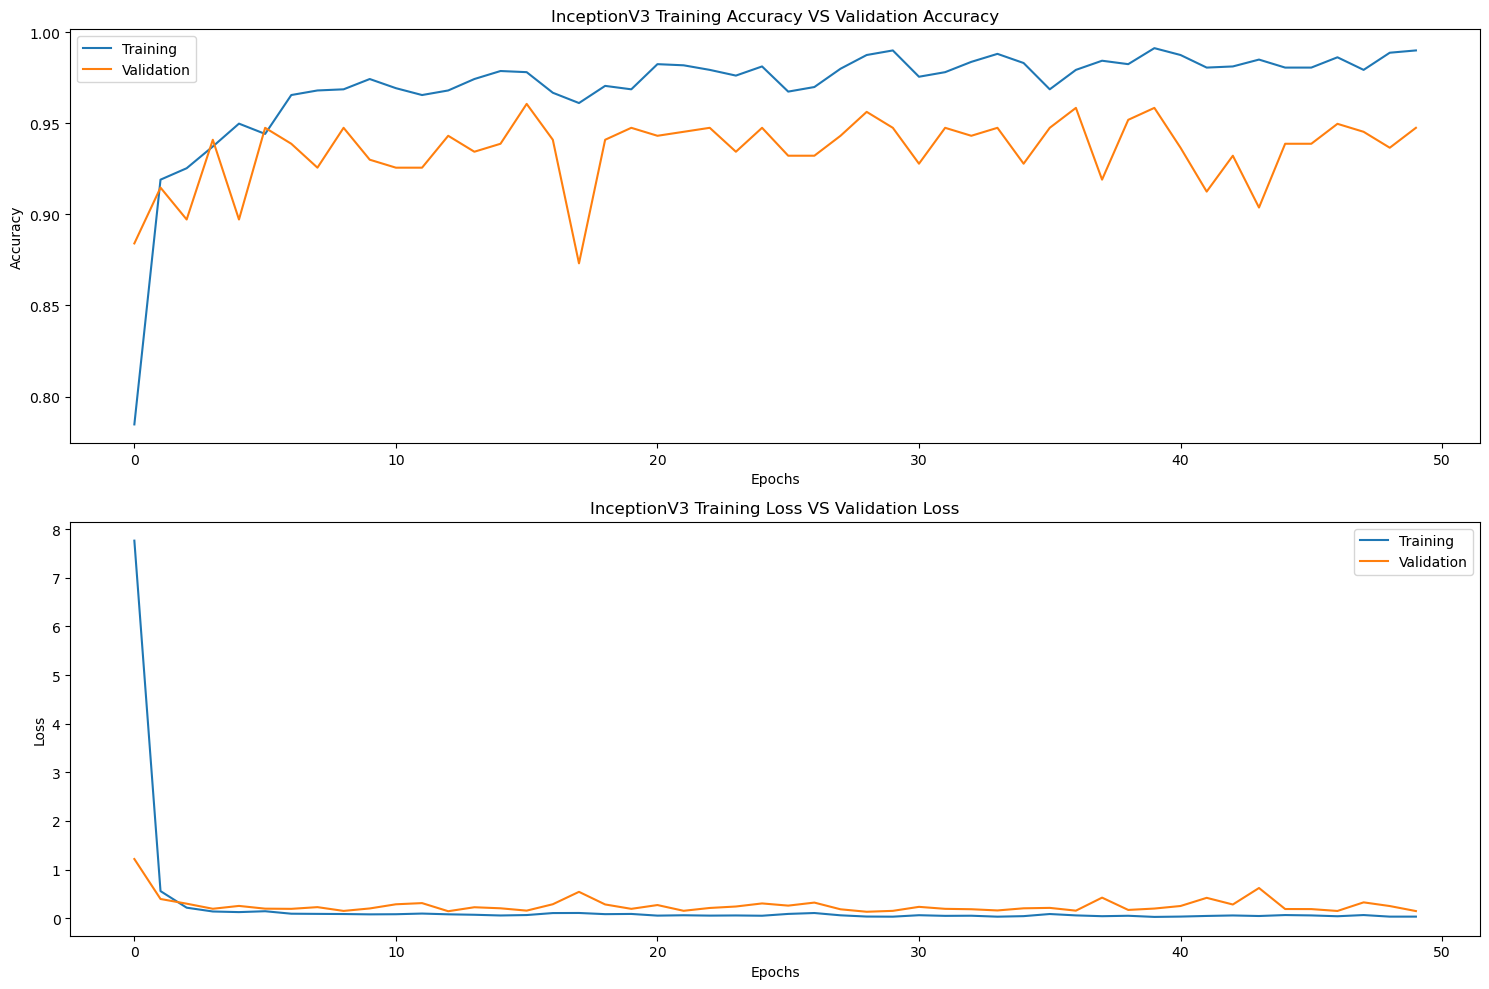

Model file path: /kaggle/working/InceptionV3/50epoch.02-0.39.h5
1/1 [==============================] - 0s 27ms/step


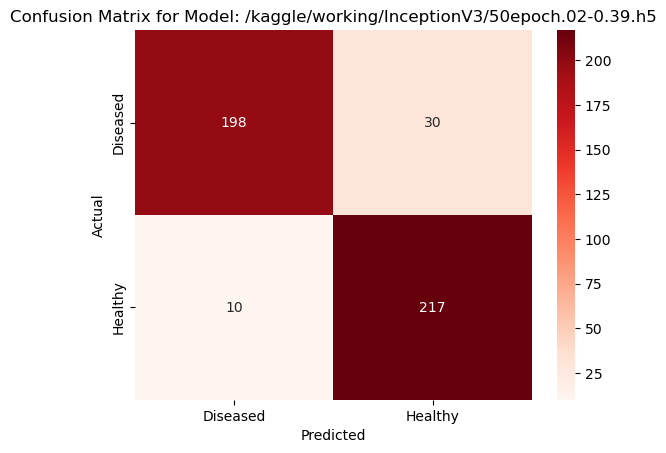

Test accuracy: 91.20879120879121
Model file path: /kaggle/working/InceptionV3/50epoch.01-1.22.h5
1/1 [==============================] - 0s 25ms/step


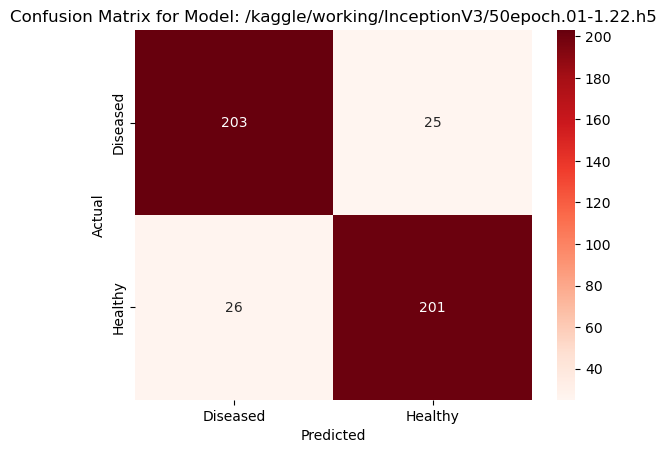

Test accuracy: 88.79120879120879
Model file path: /kaggle/working/InceptionV3/50epoch.06-0.20.h5
1/1 [==============================] - 0s 27ms/step


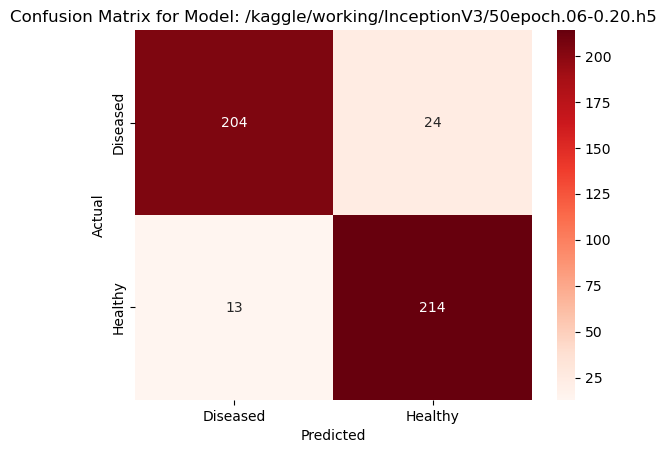

Test accuracy: 91.86813186813187
Model file path: /kaggle/working/InceptionV3/50epoch.16-0.16.h5
1/1 [==============================] - 0s 27ms/step


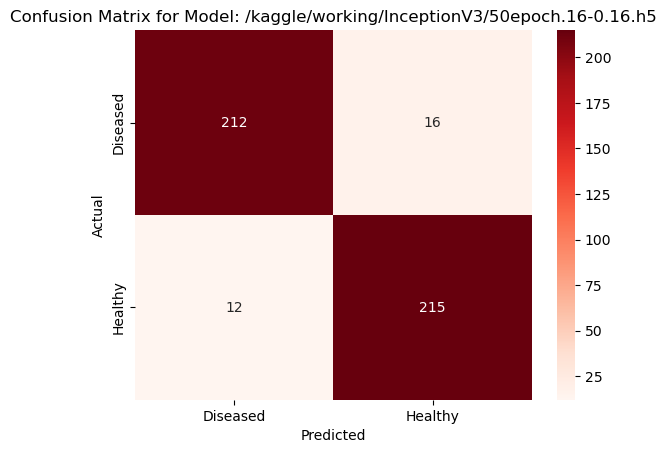

Test accuracy: 93.84615384615384
Model file path: /kaggle/working/InceptionV3/Best_InceptionV3.h5
1/1 [==============================] - 0s 29ms/step


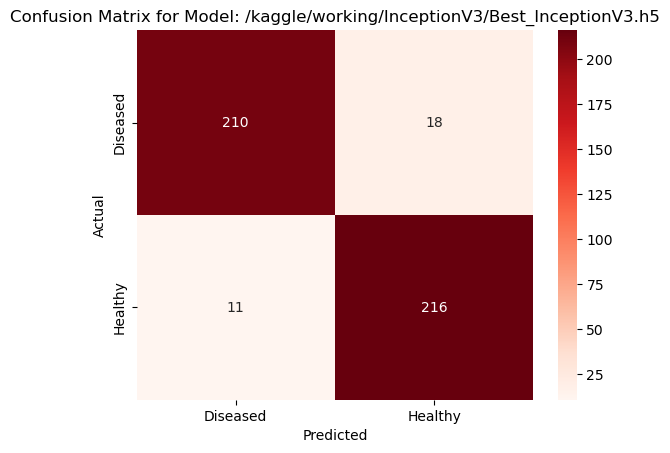

Test accuracy: 93.62637362637362
Model file path: /kaggle/working/InceptionV3/50epoch.04-0.19.h5
1/1 [==============================] - 0s 25ms/step


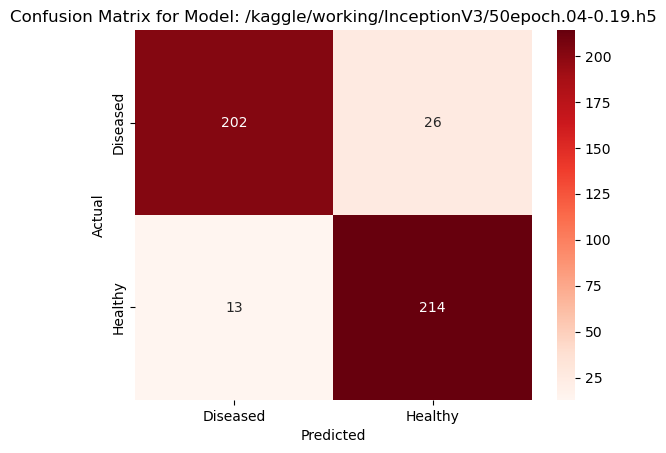

Test accuracy: 91.42857142857143


In [8]:
def main():
    train_generator, valid_generator, test_generator = get_data_generators()
    model = InceptionV3Net(train_generator.image_shape, train_generator.num_classes)
    history = compile_and_fit_model(model, train_generator, valid_generator)
    plot_training_history(history)
    save_best_model()
    evaluate_models(test_generator, train_generator)

if __name__ == "__main__":
    main()
